In [1]:
# 导入必要的库
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

In [2]:
df_2021 = pd.read_csv('user_2021.csv')

In [3]:
df_2021.head(5)

,user_id,order_no,paid_cash,create_date
0,545025,202101070067398,99.0,2021/1/7
1,545082,202106180617239,9.0,2021/6/18
2,545082,202201110846554,99.0,2022/1/11
3,545083,202109140714035,3000.0,2021/9/14
4,545083,202109140714004,3301.0,2021/9/14


In [4]:
df_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42613 entries, 0 to 42612
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      42613 non-null  int64  
 1   order_no     42613 non-null  int64  
 2   paid_cash    42613 non-null  float64
 3   create_date  42613 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 1.3+ MB


In [5]:
# 转换‘建单日期’为 日期格式

df_2021['create_date'] = pd.to_datetime(df_2021['create_date'])

# 计算最大日期为’今天‘的日期
current_date = df_2021['create_date'].max() + pd.to_timedelta(1, 'D')

In [6]:
# 计算每个用户的 Recency、Frequency、Monetary 值

rfm = df_2021.groupby('user_id').agg({
    'create_date': lambda x: (current_date - x.max()).days,# Rececny
    'order_no': 'count', # Frequency
    'paid_cash': 'sum'
}).rename(columns={
    'create_date': 'Recency',
    'order_no': 'Frequency',
    'paid_cash': 'Monetary'
})

In [7]:
rfm.head(5)

,Recency,Frequency,Monetary
user_id,,,
545025,973,1,99.0
545082,604,2,108.0
545083,723,4,6611.0
545089,249,3,498.0
545099,522,1,99.0


In [8]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11260 entries, 545025 to 648816
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    11260 non-null  int64  
 1   Frequency  11260 non-null  int64  
 2   Monetary   11260 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 351.9 KB


In [10]:
# 数据预处理
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# 使用优化的参数进行聚类
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=150,
    min_samples=3, 
    metric='euclidean', 
    cluster_selection_epsilon=0.1, 
    alpha=1.5, 
    cluster_selection_method='eom', 
    algorithm='best')
clusterer.fit(rfm_scaled)
rfm['Cluster'] = pd.Series(clusterer.labels_, index=rfm.index)

# 查看结果
print(rfm['Cluster'].value_counts())

 6    4654
 9    1872
-1    1439
 8    1113
 7     581
 0     565
 2     256
 3     247
 1     193
 5     184
 4     156
Name: Cluster, dtype: int64


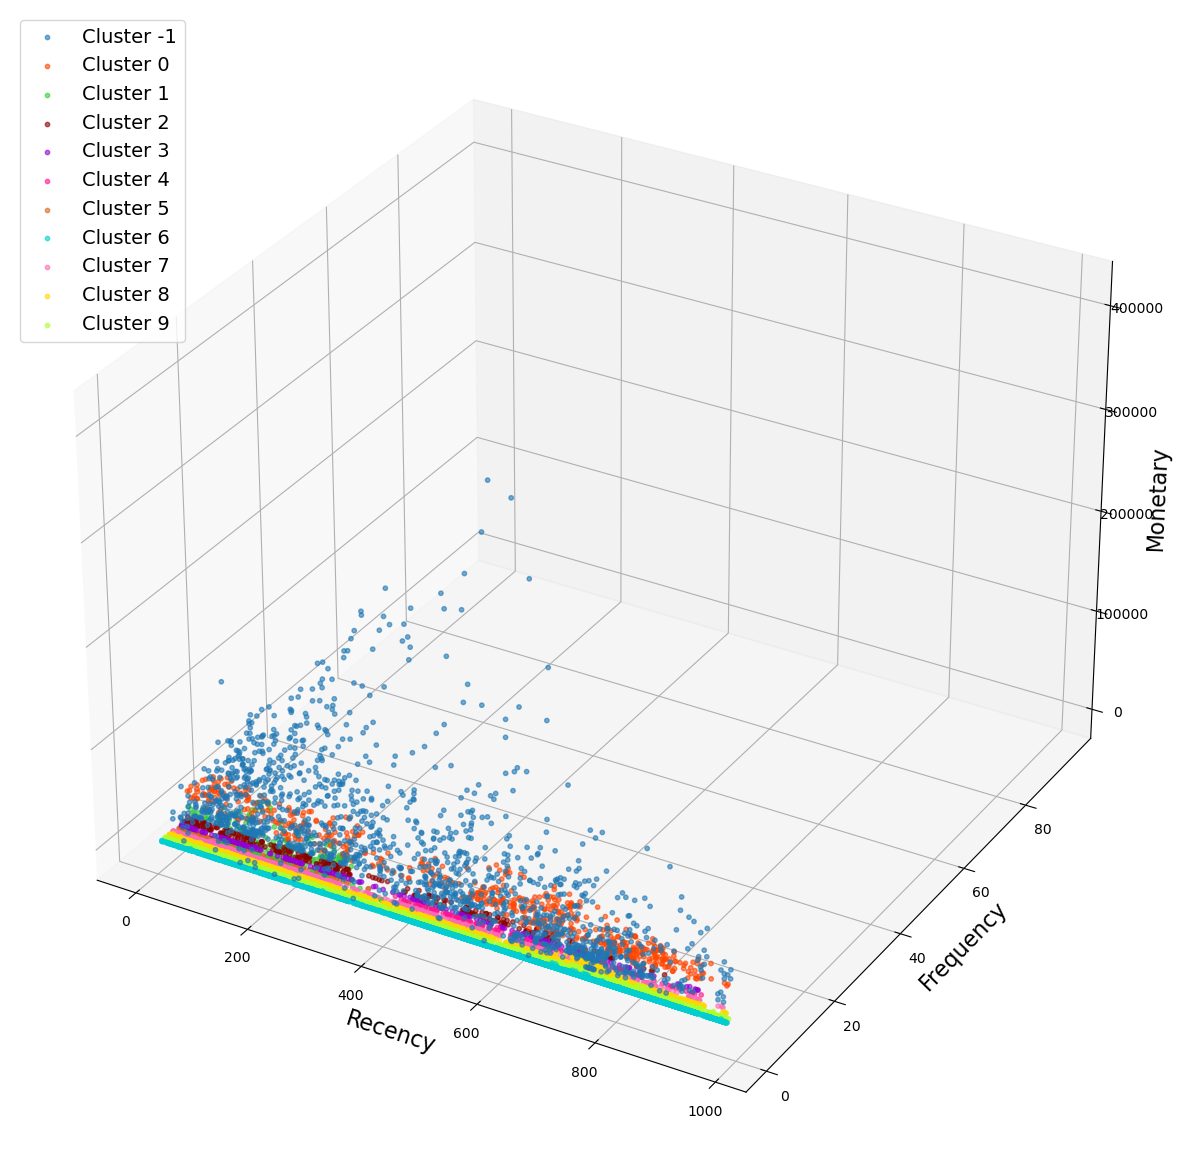

In [11]:
# 使用更为鲜明的颜色组合
colors = [
    "#1f77b4", "#ff4500", "#32cd32", "#8b0000", "#9400d3",
    "#ff1493", "#d2691e", "#00ced1", "#ff69b4", "#ffd700",
    "#adff2f", "#ffa500", "#4b0082"
]

# 进一步增加透明度
alpha_value = 0.6

# 保持点的大小
sizes = {cluster: 10 for cluster in rfm['Cluster'].unique()}

fig = plt.figure(figsize=(20, 15))
dx = fig.add_subplot(111, projection='3d')

for i, label in enumerate(sorted(rfm['Cluster'].unique())):
    dx.scatter(rfm[rfm.Cluster == label].Recency,
               rfm[rfm.Cluster == label].Frequency,
               rfm[rfm.Cluster == label].Monetary,
               c=[colors[i]],
               label='Cluster ' + str(label),
               s=sizes[label], alpha=alpha_value)

dx.set_xlabel('Recency', fontsize=16)
dx.set_ylabel('Frequency', fontsize=16)
dx.set_zlabel('Monetary', fontsize=16)
dx.legend(fontsize=14, loc='upper left')
dx.grid(True)  # 保持网格
plt.show()

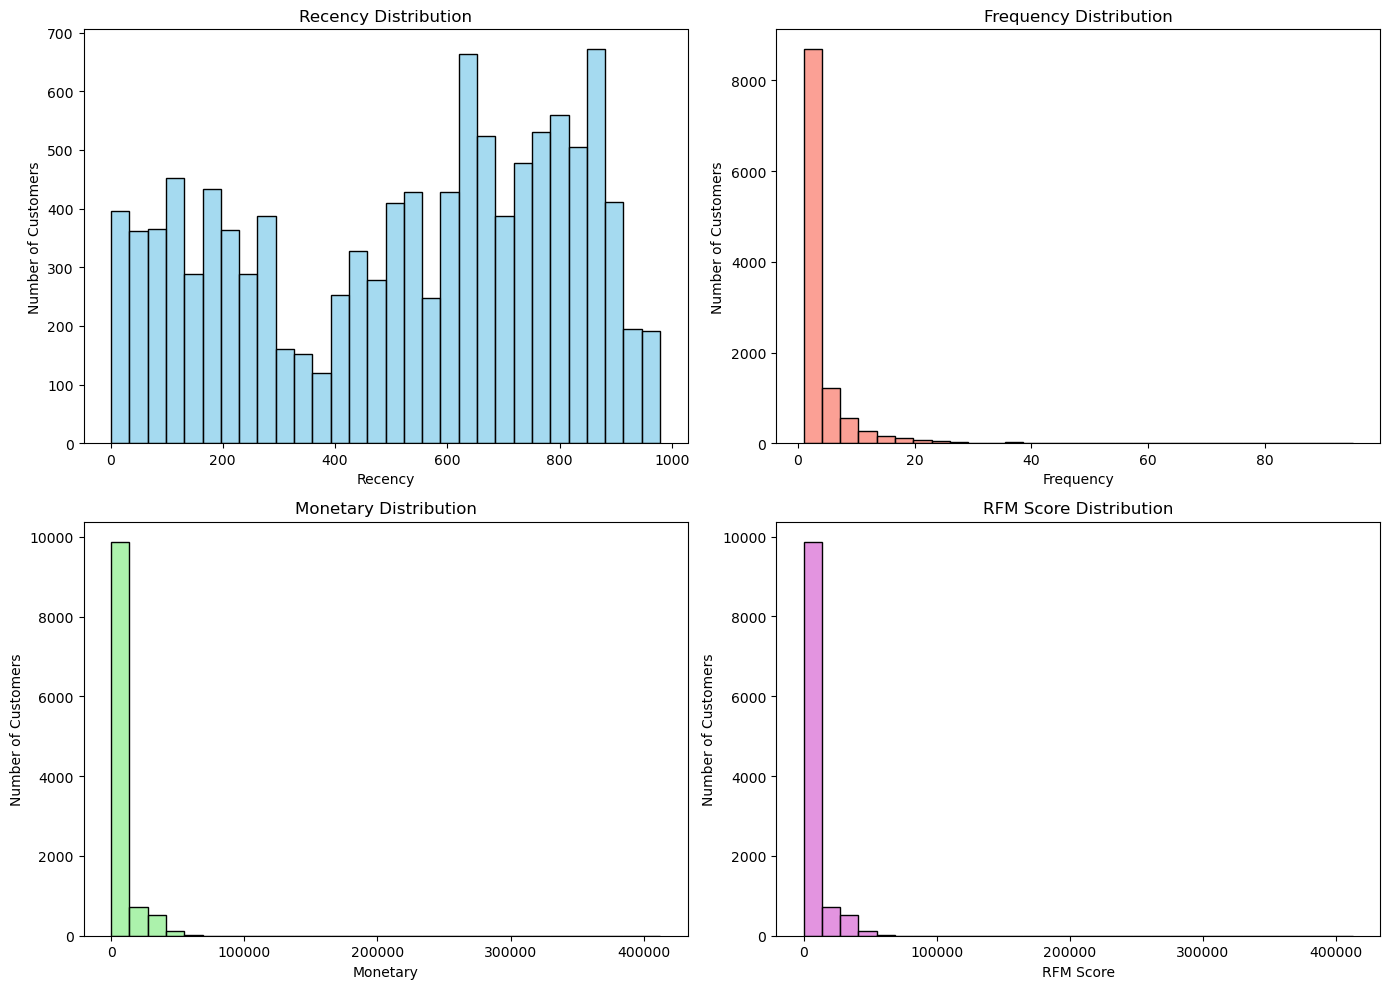

In [12]:
# 创建图形
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Recency分布图
sns.histplot(rfm['Recency'], kde=False, ax=ax[0, 0], bins=30, color='skyblue')
ax[0, 0].set_title('Recency Distribution')
ax[0, 0].set_xlabel('Recency')
ax[0, 0].set_ylabel('Number of Customers')

# Frequency分布图
sns.histplot(rfm['Frequency'], kde=False, ax=ax[0, 1], bins=30, color='salmon')
ax[0, 1].set_title('Frequency Distribution')
ax[0, 1].set_xlabel('Frequency')
ax[0, 1].set_ylabel('Number of Customers')

# Monetary分布图
sns.histplot(rfm['Monetary'], kde=False, ax=ax[1, 0], bins=30, color='lightgreen')
ax[1, 0].set_title('Monetary Distribution')
ax[1, 0].set_xlabel('Monetary')
ax[1, 0].set_ylabel('Number of Customers')

# RFM得分分布图 (需要计算RFM得分)
rfm['RFM_Score'] = rfm['Recency'] + rfm['Frequency'] + rfm['Monetary']
sns.histplot(rfm['RFM_Score'], kde=False, ax=ax[1, 1], bins=30, color='orchid')
ax[1, 1].set_title('RFM Score Distribution')
ax[1, 1].set_xlabel('RFM Score')
ax[1, 1].set_ylabel('Number of Customers')

plt.tight_layout()
plt.show()

In [13]:
# 获取总金额最大的 TOP50 数据
top_50_data = rfm.sort_values(by='Monetary', ascending=False).head(50)
top_50_data


,Recency,Frequency,Monetary,Cluster,RFM_Score
user_id,,,,,
546478,534,9,412136.00,-1,412679.00
648481,554,10,188000.00,-1,188564.00
616965,423,14,148200.00,-1,148637.00
616958,765,2,141600.00,-1,142367.00
612942,36,13,127310.00,-1,127359.00
630107,42,57,90501.41,-1,90600.41
582152,93,33,89217.61,-1,89343.61
550416,29,52,79684.00,-1,79765.00
607191,82,49,78092.33,-1,78223.33


In [25]:
filtered_rfm = rfm[rfm['Monetary'] <= 50000].copy()

In [26]:
filtered_rfm.head()

,Recency,Frequency,Monetary,Cluster,RFM_Score
user_id,,,,,
545025,973,1,99.0,6,1073.0
545082,604,2,108.0,9,714.0
545083,723,4,6611.0,-1,7338.0
545089,249,3,498.0,8,750.0
545099,522,1,99.0,6,622.0


In [27]:
# 数据预处理
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(filtered_rfm[['Recency', 'Frequency', 'Monetary']])

# 使用优化的参数进行聚类
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=120,
    min_samples=5, 
    metric='euclidean', 
    cluster_selection_epsilon=0.1, 
    alpha=1.5, 
    cluster_selection_method='eom', 
    algorithm='best')
clusterer.fit(rfm_scaled)
filtered_rfm['Cluster'] = pd.Series(clusterer.labels_, index=filtered_rfm.index)

# 查看结果
print(filtered_rfm['Cluster'].value_counts())

 9    4654
 8    1850
-1    1398
 6    1112
 7     580
 1     551
 2     254
 3     247
 0     214
 5     184
 4     153
Name: Cluster, dtype: int64


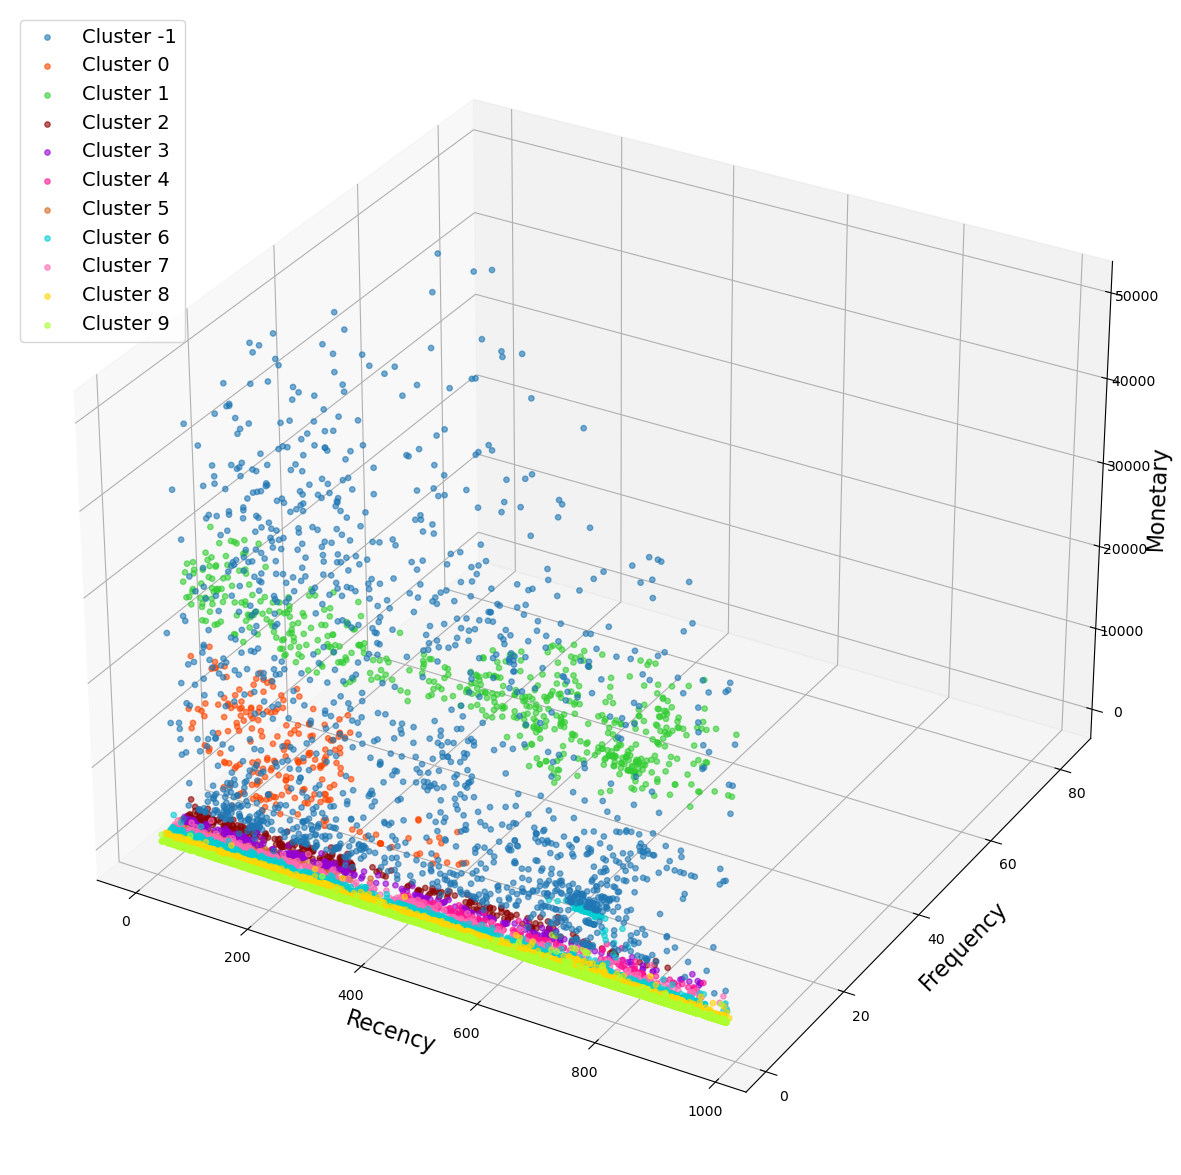

In [29]:
# 使用更为鲜明的颜色组合
colors = [
    "#1f77b4", "#ff4500", "#32cd32", "#8b0000", "#9400d3",
    "#ff1493", "#d2691e", "#00ced1", "#ff69b4", "#ffd700",
    "#adff2f", "#ffa500", "#4b0082"
]

# 进一步增加透明度
alpha_value = 0.6

# 保持点的大小
sizes = {cluster: 15 for cluster in filtered_rfm['Cluster'].unique()}

fig = plt.figure(figsize=(20, 15))
dx = fig.add_subplot(111, projection='3d')

for i, label in enumerate(sorted(filtered_rfm['Cluster'].unique())):
    dx.scatter(filtered_rfm[filtered_rfm.Cluster == label].Recency,
               filtered_rfm[filtered_rfm.Cluster == label].Frequency,
               filtered_rfm[filtered_rfm.Cluster == label].Monetary,
               c=[colors[i]],
               label='Cluster ' + str(label),
               s=sizes[label], alpha=alpha_value)

dx.set_xlabel('Recency', fontsize=16)
dx.set_ylabel('Frequency', fontsize=16)
dx.set_zlabel('Monetary', fontsize=16)
dx.legend(fontsize=14, loc='upper left')
dx.grid(True)  # 保持网格
plt.show()

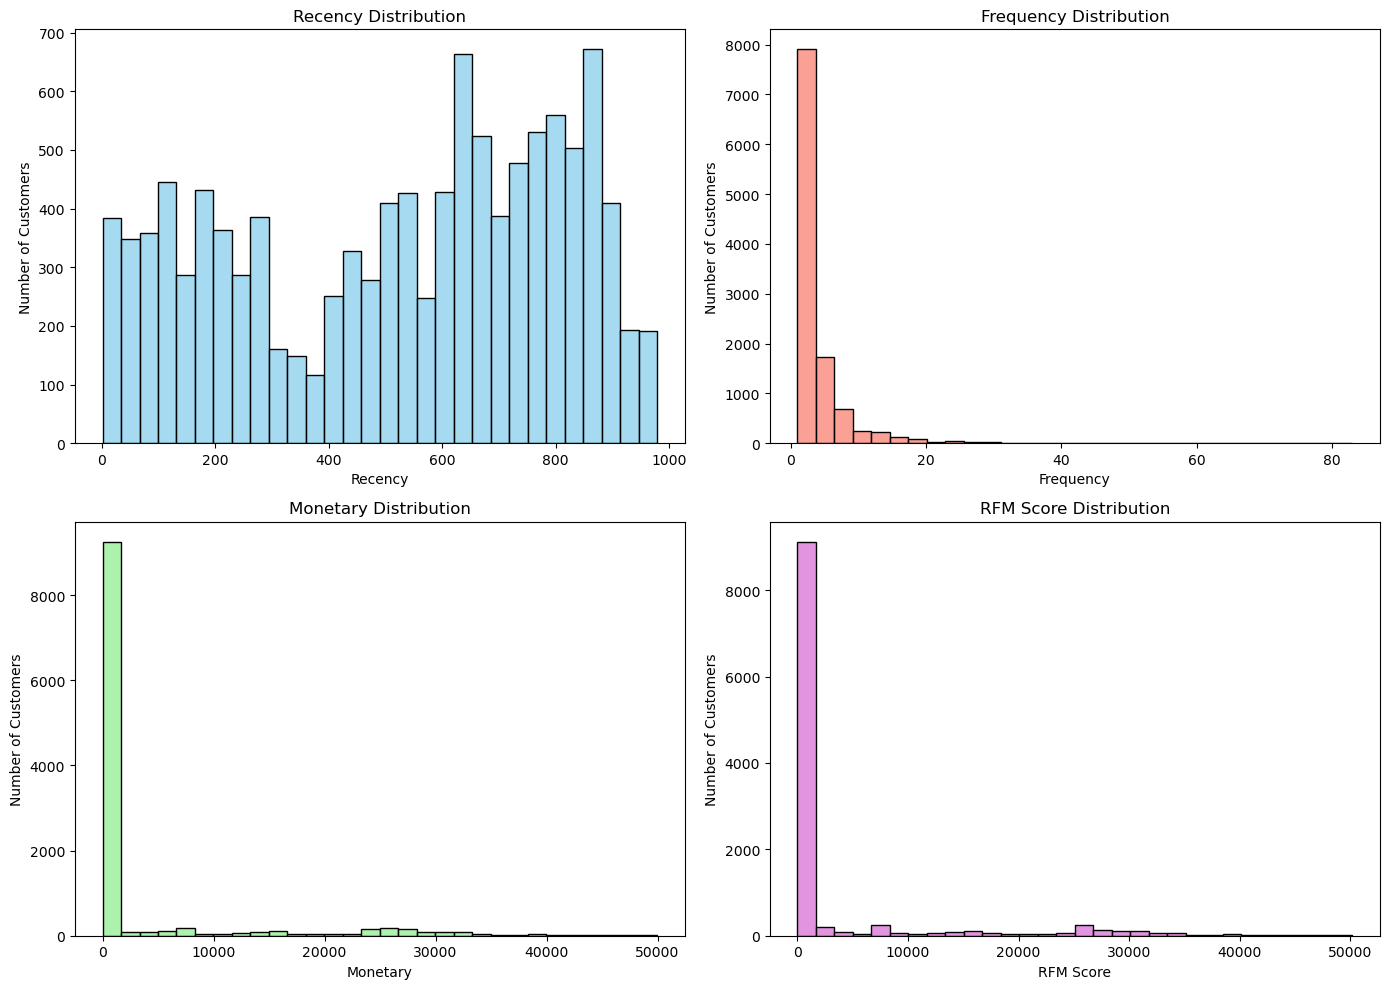

In [30]:
# 创建图形
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Recency分布图
sns.histplot(filtered_rfm['Recency'], kde=False, ax=ax[0, 0], bins=30, color='skyblue')
ax[0, 0].set_title('Recency Distribution')
ax[0, 0].set_xlabel('Recency')
ax[0, 0].set_ylabel('Number of Customers')

# Frequency分布图
sns.histplot(filtered_rfm['Frequency'], kde=False, ax=ax[0, 1], bins=30, color='salmon')
ax[0, 1].set_title('Frequency Distribution')
ax[0, 1].set_xlabel('Frequency')
ax[0, 1].set_ylabel('Number of Customers')

# Monetary分布图
sns.histplot(filtered_rfm['Monetary'], kde=False, ax=ax[1, 0], bins=30, color='lightgreen')
ax[1, 0].set_title('Monetary Distribution')
ax[1, 0].set_xlabel('Monetary')
ax[1, 0].set_ylabel('Number of Customers')

# RFM得分分布图 (需要计算RFM得分)
filtered_rfm['RFM_Score'] = filtered_rfm['Recency'] + filtered_rfm['Frequency'] + filtered_rfm['Monetary']
sns.histplot(filtered_rfm['RFM_Score'], kde=False, ax=ax[1, 1], bins=30, color='orchid')
ax[1, 1].set_title('RFM Score Distribution')
ax[1, 1].set_xlabel('RFM Score')
ax[1, 1].set_ylabel('Number of Customers')

plt.tight_layout()
plt.show()

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 复制筛选后的数据，避免直接对原数据进行修改
filtered_rfm = rfm[rfm['Monetary'] <= 40000].copy()

# Step 1: Data preprocessing 
rfm_values = filtered_rfm[['Recency', 'Frequency', 'Monetary']].values
rfm_scaled_values = scaler.transform(rfm_values)

# Step 2: Run K-means clustering
k = 5 # 此处是为了简化演示处理，便临时取值为5
kmeans = KMeans(n_clusters=k, random_state=42)
filtered_rfm['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled_values)

# Step 3: Evaluate the clusters
silhouette_avg = silhouette_score(rfm_scaled_values, filtered_rfm['KMeans_Cluster'])

# Cluster counts and silhouette score
cluster_counts = filtered_rfm['KMeans_Cluster'].value_counts()
cluster_counts, silhouette_avg

C:\Users\EDY\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


(4    3616
 1    3297
 3    2931
 2     969
 0     286
 Name: KMeans_Cluster, dtype: int64,
 0.4410463747905181)

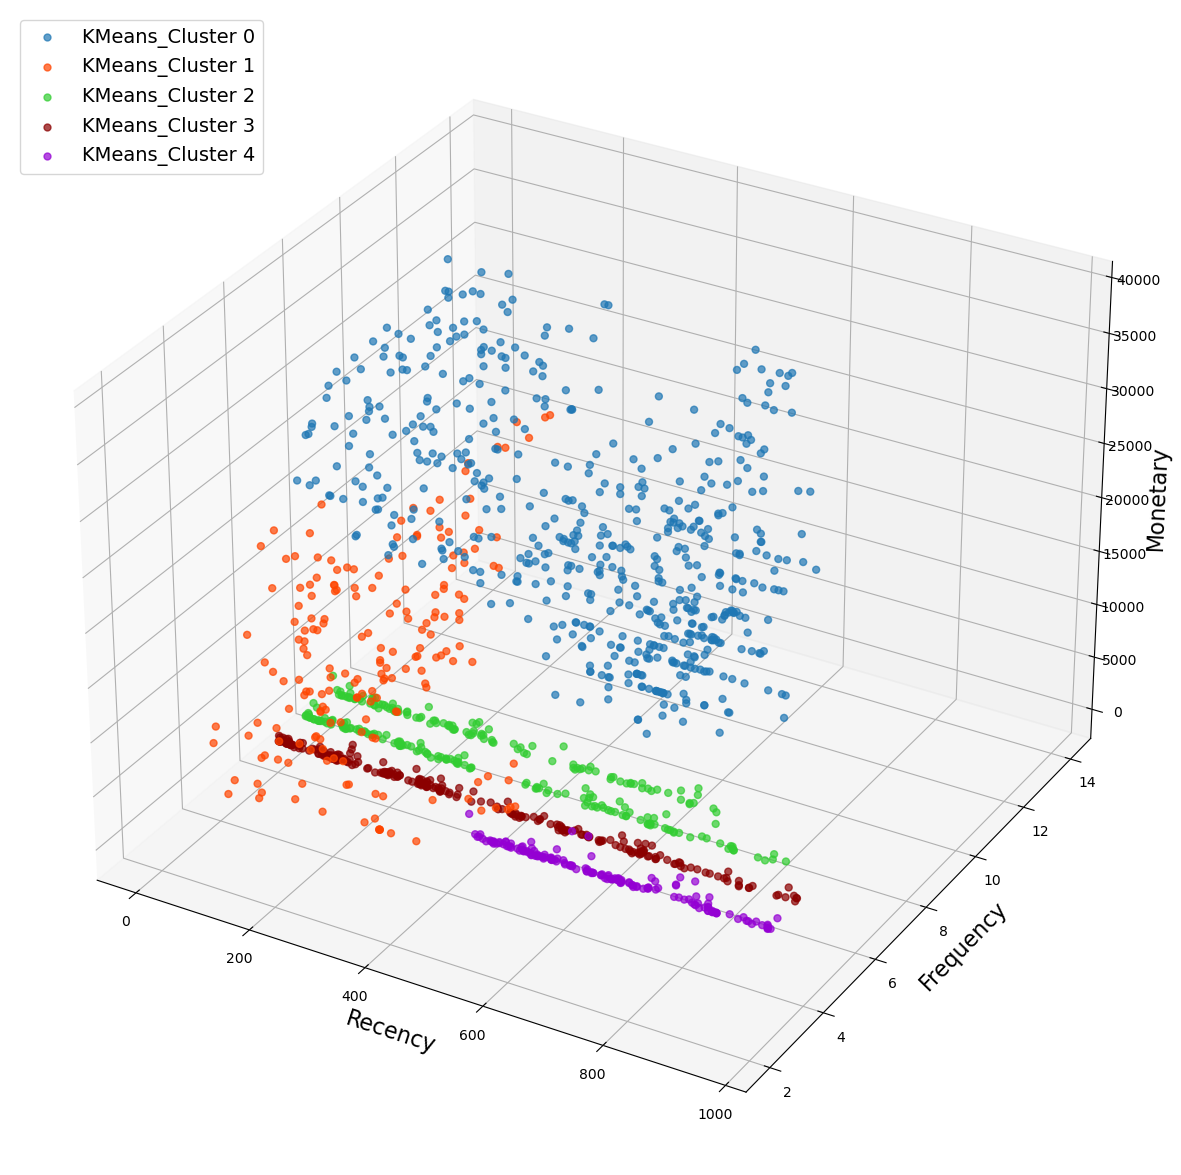

In [34]:
# 对结果进行3D可视化处理

# 使用更为鲜明的颜色组合
colors = [
    "#1f77b4", "#ff4500", "#32cd32", "#8b0000", "#9400d3",
    "#ff1493", "#d2691e", "#00ced1", "#ff69b4", "#ffd700",
    "#adff2f", "#ffa500", "#4b0082"
]

# 进一步增加透明度
alpha_value = 0.7

# 保持点的大小
sizes = {cluster: 25 for cluster in filtered_rfm['KMeans_Cluster'].unique()}

fig = plt.figure(figsize=(20, 15))
dx = fig.add_subplot(111, projection='3d')

for i, label in enumerate(sorted(filtered_rfm['KMeans_Cluster'].unique())):
    dx.scatter(filtered_rfm[filtered_rfm.Cluster == label].Recency,
               filtered_rfm[filtered_rfm.Cluster == label].Frequency,
               filtered_rfm[filtered_rfm.Cluster == label].Monetary,
               c=[colors[i]],
               label='KMeans_Cluster ' + str(label),
               s=sizes[label], alpha=alpha_value)

dx.set_xlabel('Recency', fontsize=16)
dx.set_ylabel('Frequency', fontsize=16)
dx.set_zlabel('Monetary', fontsize=16)
dx.legend(fontsize=14, loc='upper left')
dx.grid(True)  # 保持网格
plt.show()

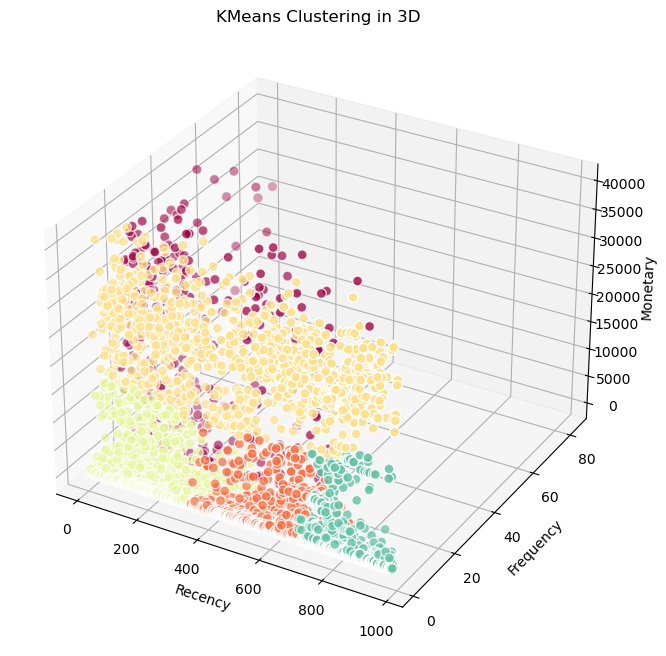

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 获取数据点的特征值
x = filtered_rfm['Recency']
y = filtered_rfm['Frequency']
z = filtered_rfm['Monetary']

# 创建一个新的图形
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 根据KMeans的结果为每个簇分配颜色
colors = plt.cm.Spectral(filtered_rfm['KMeans_Cluster'].astype(float) / k)  # 假设 k 是您的簇数量

# 在3D空间中绘制散点图
ax.scatter(x, y, z, c=colors, marker='o', edgecolor='w', s=50)

ax.set_title('KMeans Clustering in 3D')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.show()
